Clonare la sequente repository:

In [ ]:
!git clone https://github.com/ga1i13o/sem_seg_3d.git

In [ ]:
!pip install open3d==0.18.0 pyquaternion==0.9.9

In [ ]:
from glob import glob
import os
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm

**Il dataset: SemanticKITTI**

[SemanticKITTI: A Dataset for Semantic Scene Understanding of LiDAR Sequences
](https://arxiv.org/abs/1904.01416)

SemanticKITTI è un ampio dataset per **3D semantic understanding**, pensato per task come semantic segmentation.
È basato sul dataset odometry di KITTI, che raccoglie dati in ambienti come il traffico cittadino, aree residenziali, autostrade e campagne nei dintorni di Karlsruhe, in Germania. SemanticKITTI include oltre 43.000 scansioni LiDAR annotate con **28 classi**. Le classi sono progettate per coprire un ampio spettro di oggetti, incluse categorie generiche come "other-structure" o "other-vehicle", pensate per casi ambigui. Una classe outlier è inclusa per gestire errori di misurazione dovuti a riflessi o limitazioni del sensore. SemanticKITTI fornisce dati grezzi e annotati su 22 sequenze, con 23.201 scansioni per l’addestramento e 20.351 per il test.

Seguendo il paper, faremo il train di una rete di 3D Semantic Segmentation su **26 classi**. Nello specifico, le classi other-ground e other-structure sono mappate ad outlier. Inoltre, per limitare l'uso di risorse GPU, non utilizzeremo l'intero dataset, ma un sample di alcune sequenze significative sia per train (**sequenza 0,2,3**) che per validation (**sequenza 1**).

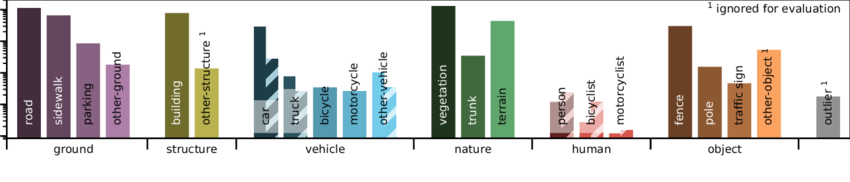

In [ ]:
!gdown "1rI8Z35_3LcapdgsGtMYcQLSS3tXp_vHh"
!unzip -qq sem_kitty.zip # unzip in non-verbose mode

Per chi avesse problemi a scaricare i dati, utilizzate questo link:
https://drive.google.com/file/d/1rI8Z35_3LcapdgsGtMYcQLSS3tXp_vHh/view?usp=drive_link
aggiungetelo al vostro drive; ed eseguite queste righe di codice:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip -qq drive/MyDrive/sem_kitty.zip

**Il modello: PointNet**

[PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation](https://arxiv.org/abs/1612.00593)

PointNet è una rete neurale progettata per elaborare direttamente **point cloud 3D non strutturate**, senza la necessità di convertirle in voxel o mesh. PointNet introduce un approccio innovativo per analizzare insiemi di punti, garantendo che l’output sia invariante rispetto all’ordine dei punti grazie all’uso di funzioni simmetriche, come il max-pooling.

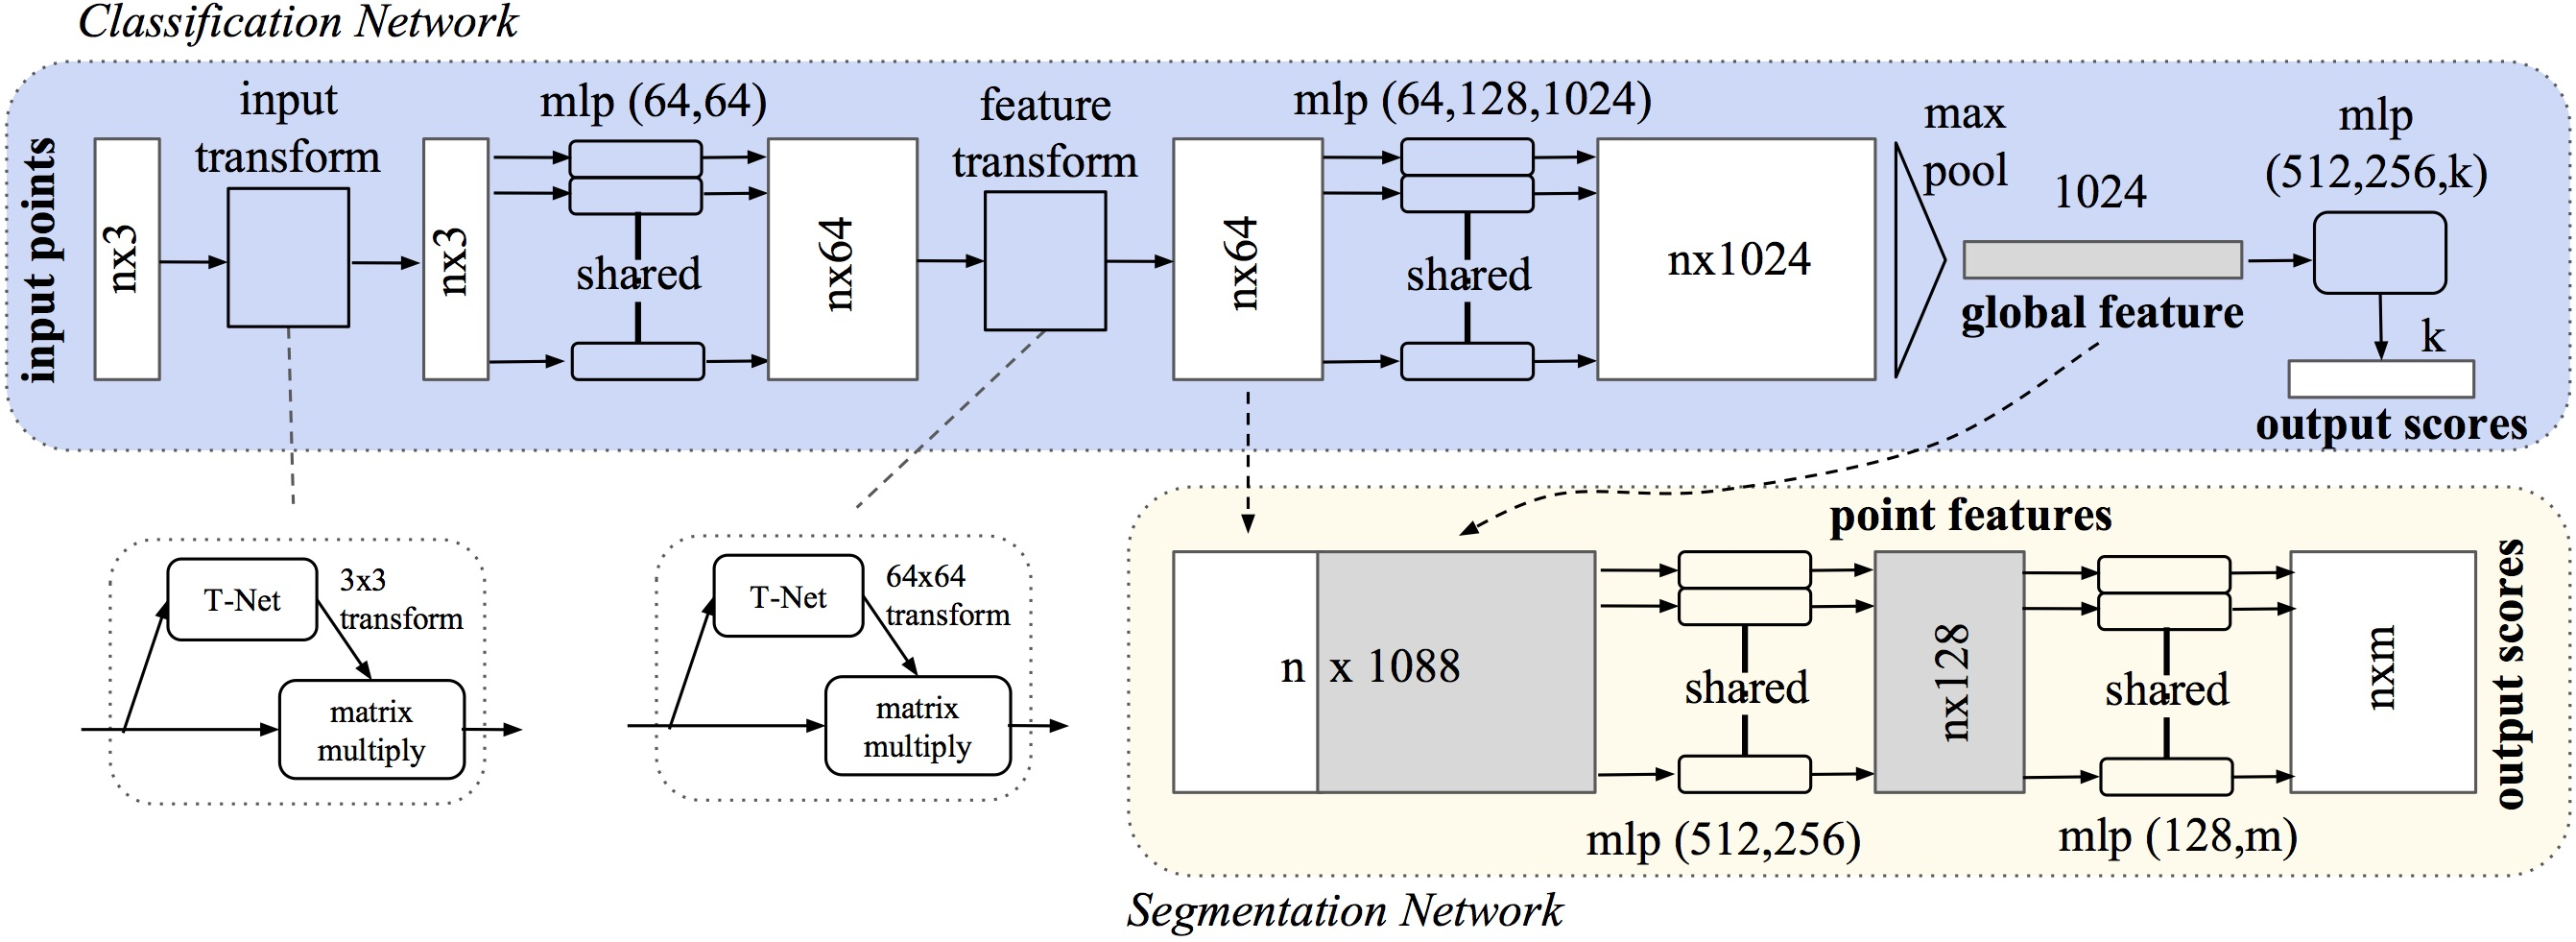

PointNet è utilizzata per task come la **classificazione di oggetti 3D, semantic segmentation e part segmentation**.

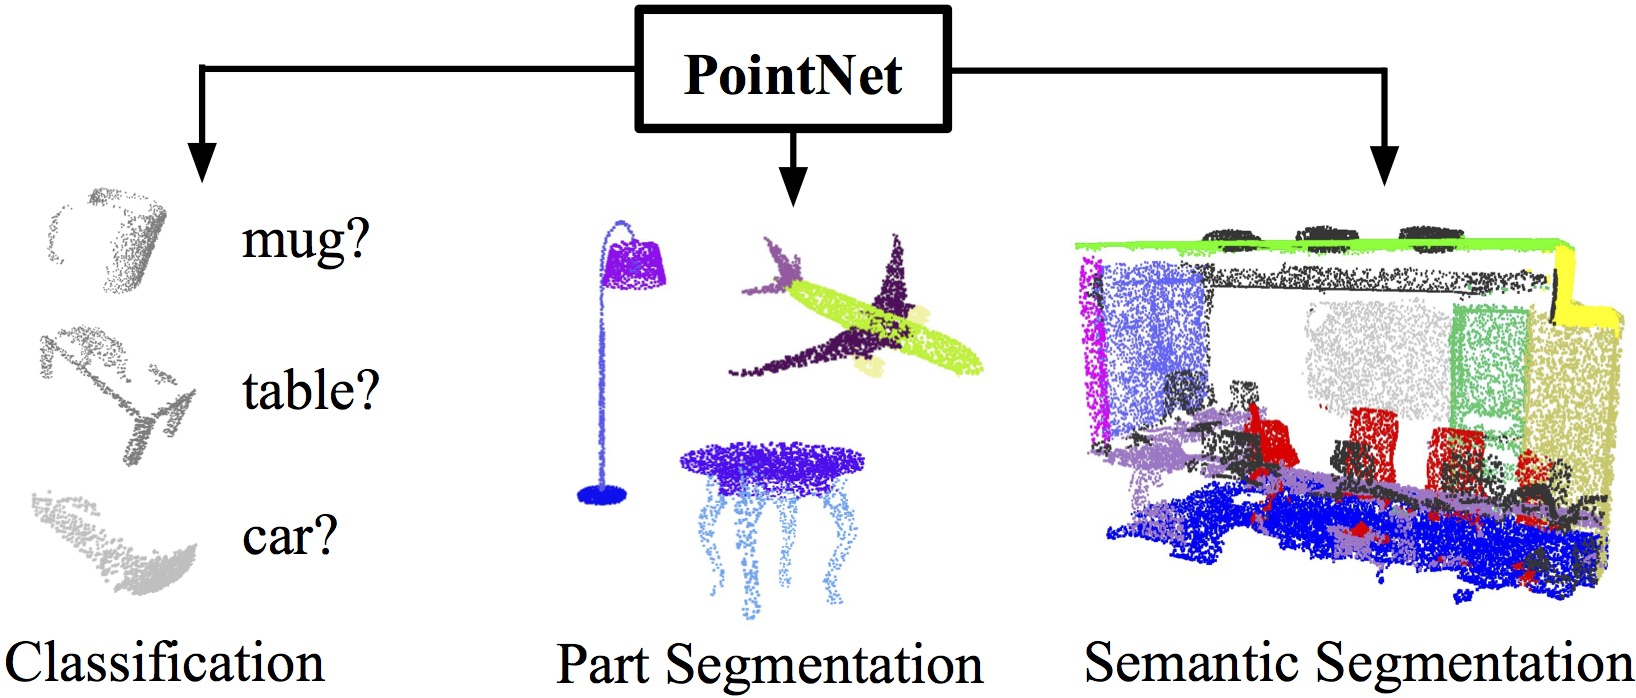

# **STEP 1**


# **STEP 2**
Creare la classe Dataset, la quale si occuperà di accedere a un sample di dati e processarlo.
Ogni classe Dataset personalizzata deve implementare tre funzioni: __init__, __len__ e __getitem__.


1.   La funzione __init__ viene eseguita *una* volta, quando si istanzia l'oggetto Dataset. All'interno di questa funzione, si inizializzano le informazioni necessarie ad accedere e caricare le immagini (e.g. la cartella contenente le immagini, il file delle annotazioni, eventuali trasformazioni...).
2.   La funzione __len__ restituisce il numero di sample del nostro set di dati.
3. La funzione __getitem__ carica e restituisce un sample dal dataset all'indice idx indicato. In base all'indice, si identifica la posizione dell'immagine e della label nelle corrispondenti cartelle. Una volta caricate, vengono chiamate le eventuali funzioni di trasformazione. Infine, l'immagine del tensore e l'etichetta corrispondente vengono restituite in una tupla.

In [ ]:
from torchvision import transforms
from sem_seg_3d.data_processing import ToTensor, Normalize, readpc, sample

class PointCloudData(Dataset):
    def __init__(self, dataset_path, sequences=[1], num_points=2000, max_dist=15, min_dist=4):
        # transform distances to squares (code optimization)
        max_dist *= max_dist
        min_dist *= min_dist
        self.max_dist = max_dist
        self.min_dist = min_dist

        self.dataset_path = dataset_path
        self.n_points = num_points
        self.transforms = transforms.Compose([
            Normalize(),
            ToTensor()
        ])

        all_seqs = os.listdir(os.path.join(self.dataset_path, "sequences"))
        self.pc_paths = []
        self.lb_paths = []
        for seq in all_seqs:
            if int(seq) in sequences:
                pc_path = os.path.join(self.dataset_path, "sequences", seq, "velodyne")
                lb_path = os.path.join(self.dataset_path, "sequences", seq, "labels")

                self.pc_paths += sorted(glob(pc_path + '/*'))
                self.lb_paths += sorted(glob(lb_path + '/*'))
        assert(len(self.pc_paths) == len(self.lb_paths))

    def __len__(self):
        return len(self.pc_paths)

    def __getitem__(self, idx):
        pcpath = self.pc_paths[idx]
        lbpath = self.lb_paths[idx]
        # load points and labels
        pointcloud, labels = readpc(pcpath, lbpath, max_dist=self.max_dist, min_dist=self.min_dist)
        pointcloud, labels = sample(pointcloud, labels, self.n_points)

        # transform
        torch_pointcloud = self.transforms(pointcloud)
        torch_labels      = torch.from_numpy(labels)
        return torch_pointcloud, torch_labels

In [ ]:
train_ds  = PointCloudData(dataset_path = "geo_dataset/dataset", sequences=[0, 2, 3], num_points=5000)
val_ds    = PointCloudData(dataset_path = "geo_dataset/dataset", sequences=[1],  num_points=5000)

**VISUALIZZAZIONE DEI DATI**

In questa sezione, visualizziamo i dati di SemanticKITTI. Questo task prevede l'elaborazione di point cloud, ovvero insiemi di punti nello spazio tridimensionale descritti dalle coordinate (x,y,z). A ogni punto è associata una label semantica che determina il colore del punto nella visualizzazione, utilizzando uno schema cromatico predefinito.

Il codice fornito permette di caricare una point cloud e le relative label (readpc) da una specifica sequenza del dataset. Successivamente, tramite una funzione di mappatura (remap_to_bgr), le label originali di SemanticKITTI vengono convertite in colori RGB, in modo che ogni classe semantica sia rappresentata da un colore distintivo. Infine, la funzione visualize3DPointCloud consente di visualizzare la point cloud colorata in 3D, fornendo un'intuizione visiva delle categorie semantiche presenti nella scena.

Visualizzate le scene appartenenti alle varie sequenze.

In [ ]:
from sem_seg_3d.data_processing import remap_to_bgr, readpc, semantic_kitti_color_scheme, visualize3DPointCloud

sequence_idx =  ...  #TODO  # provide an index within the dataset length
pointcloud, labels = train_ds[sequence_idx]
labels = remap_to_bgr(labels, semantic_kitti_color_scheme)
visualize3DPointCloud(pointcloud, labels)

**DATALOADER**

Il dataset recupera le caratteristiche e le etichette del nostro dataset un campione alla volta. Durante il training di un modello, vogliamo passare i campioni in “minibatch”, rimescolare i dati a ogni epoca per ridurre l'overfitting del modello e usare il multiprocessing di Python per velocizzare il processo di recupero dei dati.

DataLoader è lo strumento che utilizziamo. In particolare, il DataLoader estrae istanze di dati dal Dataset, le raccoglie in batch e le restituisce per lo svolgimento del training loop. Il DataLoader funziona con tutti i tipi di dataset, indipendentemente dal tipo di dati che contengono.

In [ ]:
batch_size =  ... #TODO
train_loader  = DataLoader( dataset=train_ds,  batch_size=batch_size, shuffle=True, drop_last=True)
val_loader    = DataLoader( dataset=val_ds,    batch_size=batch_size, shuffle=False )

## **STEP 2**

Una volta creato il nostro Dataset, costruiamo il modello di segmentazione: PointNet.

In [ ]:
import sem_seg_3d.PointNets_model as pt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pointnet = pt.PointNetSeg(classes=26)
pointnet = pointnet.to(device)

Definiamo gli strumenti che ci servieranno a trainare la rete: il numero di epoche, il learning rate, l'optimizer e la loss.


In [ ]:
num_epochs = ...         #TODO
learning_rate = ...      #TODO
optimizer = ...          #TODO

def pointNetLoss(ouputs, labels, m3x3, m64x64, alpha=0.0001):
    criterion = torch.nn.NLLLoss()
    bs =  ouputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs, 1, 1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs, 1, 1)
    if ouputs.is_cuda:
        id3x3 = id3x3.cuda()
        id64x64 = id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3, m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64, m64x64.transpose(1, 2))
    return criterion(ouputs, labels) + alpha * (torch.norm(diff3x3) + torch.norm(diff64x64))/float(bs)

# **STEP 3**

Nello step 1 e step 2, abbiamo definito tutto il necessario per addestrare la nostra rete di segmentazione: abbiamo creato il **dataset**, costruito il **dataloader**, inizializzato il **modello** e stabilito gli **iperparametri**.

A questo punto, dobbiamo implementare il training loop, che è il fulcro del processo di training della rete neurale. Ecco i passi fondamentali da seguire:

1. **Impostare la rete in modalità di training**: prima di iniziare il ciclo di addestramento, assicurarsi di impostare il modello in modalità train con model.train().

2. **Iterare sui dati**: utilizzando il dataloader, dovrete iterare su ciascun batch del dataset. Per ogni batch, eseguite i seguenti passaggi:

* **Input e target**: ottenere gli input (le immagini) e i target (le etichette) dal batch.

* **Forward pass**: passare gli input attraverso il modello per ottenere le prediction (output del modello).

* **Calcolo della loss**: confrontare le prediction con i target utilizzando la funzione di loss definita (ad esempio, cross-entropy loss per la segmentazione).

3. **Backpropagation**:

* **Zero gradients**: azzerare i gradienti accumulati in ogni iterazione con optimizer.zero_grad().

* **Loss backward**: eseguire la backpropagation della loss con loss.backward() per calcolare i gradienti rispetto ai pesi del modello.

* **Ottimizzazione**: aggiornare i pesi del modello utilizzando l'optimizer con optimizer.step(). Questo permette di minimizzare la loss.

Logging e validazione (opzionale): durante il training, potete monitorare l'andamento della loss e altre metriche per tenere traccia dei progressi. E' utile eseguire un'operazione di validation su un set di dati separato a intervalli regolari per monitorare il comportamento del modello.

Ripetete questo ciclo per un numero predefinito di epoch.

In [ ]:
def train(pointnet, optimizer, train_loader):
    pointnet.train()
    tq = tqdm(total=len(train_loader) * batch_size, ncols=100, leave=True, position=0)
    tq.set_description('epoch %d' % (epoch))
    loss_records = []
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device).float()
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs, m3x3, m64x64 = pointnet(inputs.transpose(1, 2))
        loss = pointNetLoss(outputs, labels, m3x3, m64x64)
        loss.backward()
        optimizer.step()
        tq.update(batch_size)
        tq.set_postfix(loss='%.6f' % loss)
        loss_records.append(loss.item())
    loss_train_mean = np.mean(loss_records)
    return loss_train_mean


In [ ]:
def val(model, val_loader):
  pointnet.eval()
  correct = total = 0
  # validation
  with torch.no_grad():
      for data in val_loader:
          inputs, labels = data
          inputs = inputs.to(device).float()
          labels = labels.to(device)
          outputs, _, _ = pointnet(inputs.transpose(1, 2))
          _, predicted = torch.max(outputs.data, 1)

          total += labels.size(0) * labels.size(1)
          correct += (predicted == labels).sum().item()

  val_acc = 100.0 * correct / total
  print('Valid accuracy: %d %%' % val_acc)

  return val_acc


In [ ]:
max_acc = -1
save_model_path = 'checkpoints'
os.makedirs(save_model_path, exist_ok=True)
for epoch in range(num_epochs):
  loss_train_mean = train(pointnet, optimizer, train_loader)
  with torch.no_grad():  # Disabilita il calcolo dei gradienti durante la validazione
    acc = val(pointnet, val_loader)
  if acc > max_acc:
    print("Save best model! Epoch: ", epoch)
    max_acc = acc
    torch.save(pointnet.state_dict(), os.path.join(save_model_path, 'best.pth'))


# **STEP 4**

**CAMPIONAMENTO DEI PUNTI**

Nel training appena eseguito, abbiamo utilizzato scene campionate con 5000 punti (num_points = 5000). Adesso vi chiediamo di **modificare questo parametro per analizzare come il numero di punti campionati (num_points) influisce sulle performance del modello**.
In particolare:

1.   **Visualizzazione dei punti campionati**: ripetete la visualizzazione dei dati svolta nello STEP 2, ma questa volta variando il valore di *num_points*.
Provate con valori diversi, come 1000,  5000 e 20000 punti, per osservare come cambia la densità e la rappresentazione della point cloud.
2.   **Training**: Ripetete il processo di training utilizzando i diversi valori di num_points.
Al termine di ciascun training, annotate i risultati, confrontando le metriche ottenute.



In [ ]:
# TODO

# **STEP 5**
**DATA AUGMENTATION**

In questo step vogliamo introdurre alcune **data augmentation** per valutare se e come le performance del modello cambiano. Partite dal migliore valore di num_sampled_point trovato nello STEP 4 e applicate le seguenti tecniche di data augmentation durante il training:


1.   **Point Jitter**: Applicate un rumore gaussiano N(0,σ) alle coordinate (x,y,z) dei punti nella point cloud.
Provate con diversi valori di σ (ad esempio, 0.01, 0.05, 0.1) per osservare come il modello reagisce a diverse intensità di rumore.
2.   **Point Dropout**: Applicate una maschera a una percentuale casuale di punti nella point cloud sostituendo le loro coordinate con  (0,0,0). Provate con diverse percentuali di dropout (ad esempio, 10%, 30%, 50%).



In [ ]:
# TODO